# The Elevation of Montreal

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import pandas as pd
import numpy as np
import requests
import json
import time
import os
import shapefile

%matplotlib inline

## Full disclaimer: 

I'm a self-taught novice Python programmer and there are most likely a lot of things wrong with this code. I used this as an opportunity to practice some of what I've learned so far

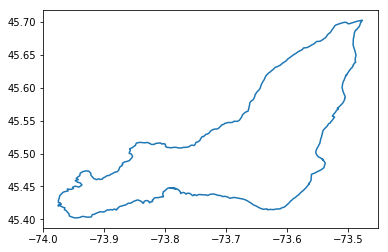

In [2]:
#Started with a list of coordinates derived from the shapefile I found on Open Data portal

perimeter_file = 'perimeter.csv'
df = pd.read_csv(perimeter_file)
plt.plot(df['longitude'],df['latitude'])

In [3]:
#Built a ploygon to later check if points are within it
points = [(row['latitude'],row['longitude']) for index, row in df.iterrows()]
points.append(points[0])
polygon = Polygon(points)

In [4]:
max_lon = max(df['longitude'])
max_lat = max(df['latitude'])
min_lon = min(df['longitude'])
min_lat = min(df['latitude'])

In [5]:
lon_range = abs(max_lon-min_lon)
lat_range = abs(max_lat-min_lat)

In [6]:
lat_bins = 75
lon_bins = 300

In [7]:
lat_incr = lat_range/lat_bins
lon_incr = lon_range/lon_bins

In [8]:
#Here we break up latitude range in 75 increments (bin size) and record all points within the min and max longitude,
#checking if it is inside the ploygon representing the outer limits of the island. I added line breaks where I would
#start a new row ID given that it would be plotted as individual lines and had to account for line breaks

data = []
total_break = 0

for y in range(lat_bins):
    lat_bin_min = min_lat + y*lat_incr
    lat_bin_max = min_lat + (y+1)*lat_incr
    
    lon_bin_all = df[df['latitude'].between(lat_bin_min,lat_bin_max)]['longitude']
    
    lon_bin_max = max(lon_bin_all)
    lon_bin_min = min(lon_bin_all)
    lon_bin_range = lon_bin_max-lon_bin_min
    lon_bin_incr = lon_bin_range/lon_incr
    lon_bin_incr_cnt = int(lon_bin_incr)
    
    line_break = False
    break_cnt = 0
    
    for x in range(lon_bin_incr_cnt):
        point_lat = round(lat_bin_min,6)
        point_lon = round(lon_bin_min+x*lon_incr,6)
        curr_point = Point(point_lat,point_lon)
        check = polygon.contains(curr_point)
        if check:
            if line_break is True:
                line_break = False
                break_cnt += 1
            data.append([y+1,y+1+break_cnt+total_break, point_lat, point_lon,check])
        else:
            line_break = True
    total_break += break_cnt

elevation_points = pd.DataFrame(data,columns=['BinID','RowID','Latitude','Longitude','IsWithinPolygon'])

In [10]:
#Use API to get elevation for all the points found

url = 'https://api.jawg.io/elevations'
token = 'TOKEN HERE'

#API somehow didn't allow me to submit more than 150 coordinates at once
batch_size = 150
raw = []
for i in range(0,len(elevation_points),batch_size):
    coord_all = ''
    for index, row in elevation_points.iterrows():
        if index >= i  and index < i+batch_size :
            coord_all += str(row['Latitude']) + ',' + str(row['Longitude']) + '%7C'
    coord_all = coord_all[:-3]
    final_url = url+'?locations=' + coord_all + '&access-token=' + token
    request = requests.get(final_url)
    for item in request.json():
        raw.append([item['elevation'],item['location']['lat'],item['location']['lng'],item['resolution']])
    time.sleep(2)

df_elev = pd.DataFrame(raw, columns = ['Elevation','Lat','Lon','Resolution'])

In [11]:
elevation_data = pd.merge(elevation_points, df_elev, how = 'left', left_on=['Latitude','Longitude'], right_on=['Lat','Lon'])
elevation_data= elevation_data[['RowID','Latitude','Longitude','Elevation']]

min_elev = min(elevation_data['Elevation'])
max_elev = max(elevation_data['Elevation'])

scale_factor = 8

elevation_data['Elevation_Scaled'] = elevation_data['Elevation']/max_elev*scale_factor
elevation_data['Latitude_Elev'] = elevation_data['Latitude'] + elevation_data['Elevation_Scaled']*lat_incr

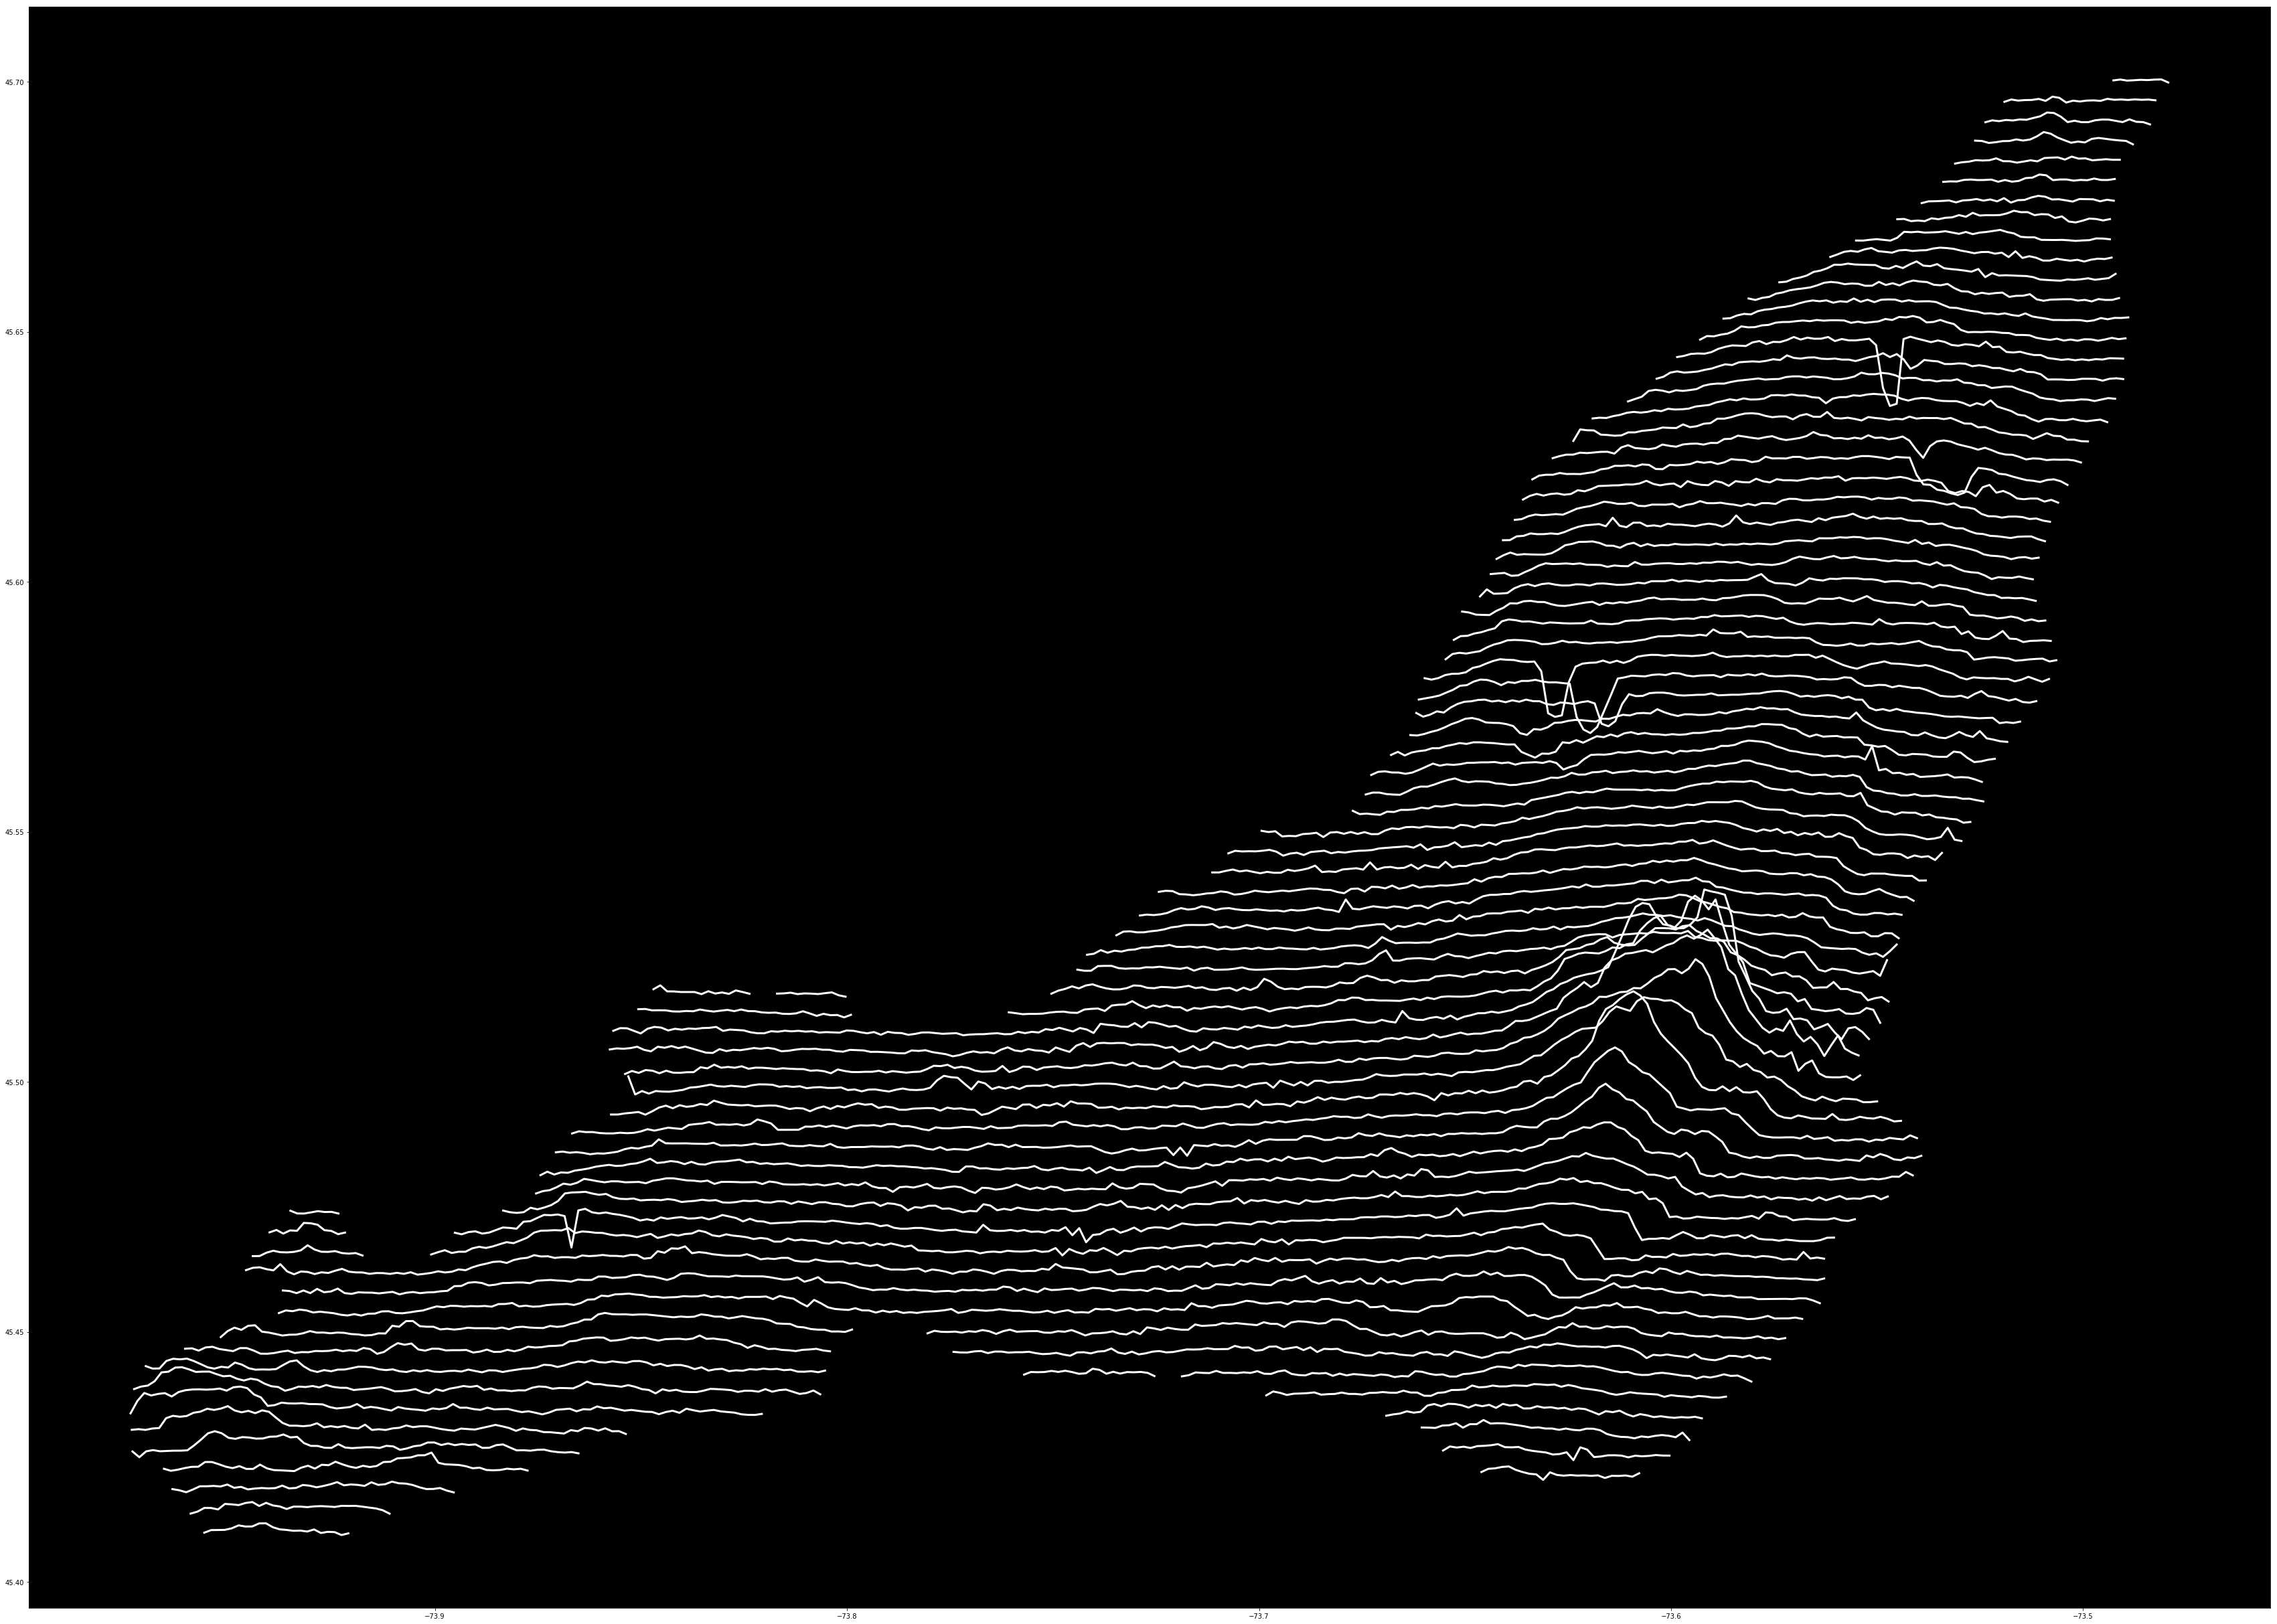

In [12]:
fig, ax = plt.subplots(figsize =(60,44))
ax.set_facecolor('black')
ax.grid(False)
for z in range(lat_bins+total_break):
    dftmp = elevation_data[elevation_data['RowID'] == z+1]
    if len(dftmp) > 5:
        ax.plot(dftmp['Longitude'],dftmp['Latitude_Elev'],linestyle = 'solid',c= 'w',linewidth=3.0)

plt.savefig('mtl_elevation.png')